In [2]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 3

* The CSV files are located in the root of the directory containing the iPython Notebook
* To avoid any sort of issues realted to improper column names, some of the field names have been altered
* The 'date' field is currently is of type 'object' and has been converted into 'datetime'

In [14]:
monthly_data = pd.read_csv("Monthly_data_cmo.csv")
cmo_msp_mandi = pd.read_csv("CMO_MSP_Mandi.csv")

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
monthly_data = pd.read_csv('Monthly_data_cmo.csv', parse_dates=['date'],date_parser=dateparse)
monthly_data = monthly_data[((monthly_data['modal_price'] <= monthly_data['max_price']) & 
                 (monthly_data['modal_price'] >= monthly_data['min_price']))]

In [15]:
monthly_data.head()

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name,state_name
0,Ahmednagar,Bajri,2015,April,79,1406,1538,1463,2015-04-01,Ahmadnagar,Maharashtra
1,Ahmednagar,Bajri,2016,April,106,1788,1925,1875,2016-04-01,Ahmadnagar,Maharashtra
2,Ahmednagar,Wheat(Husked),2015,April,1253,1572,1890,1731,2015-04-01,Ahmadnagar,Maharashtra
3,Ahmednagar,Wheat(Husked),2016,April,387,1750,2220,1999,2016-04-01,Ahmadnagar,Maharashtra
4,Ahmednagar,Sorgum(Jawar),2015,April,3825,1600,2200,1900,2015-04-01,Ahmadnagar,Maharashtra


In [5]:
ts = monthly_data.set_index('date')

In [6]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series.rolling(timeseries, window=12,center=False).mean()
    rolstd = pd.Series.rolling(timeseries, window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

/Users/sumitsaha/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

def get_season(ts_log,commodity,apmc):
    decomposition = seasonal_decompose(ts_log.values,freq=10)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

#     plt.subplot(411)
#     plt.plot(ts_log, label='Original')
#     plt.legend(loc='best')
#     plt.subplot(412)
#     plt.plot(trend, label='Trend')
#     plt.legend(loc='best')
#     plt.subplot(413)
    try:
        plt.plot(seasonal,label='{}-{}-Seasonality'.format(apmc,commodity))
        plt.legend(loc='best')
        plt.show()
    except:
        pass
#     plt.subplot(414)
#     plt.plot(residual, label='Residuals')
#     plt.legend(loc='best')
#     plt.tight_layout()
    


In [8]:
def sub(commodity,apmc):
    sub_ts = ts[(ts['Commodity']==commodity) & (ts['APMC']==apmc)]
    sub_ts = sub_ts['modal_price'].sort_index(ascending=True)
    ts_log = np.log(sub_ts)
    return ts_log

## Seasonality Type
### Note: Running for only 1 APMC center. Please remove [ : 1] for complete output

##### From the following plots we can infer that seasonality for almost all combinations of APMC and Commodity is ADDITIVE


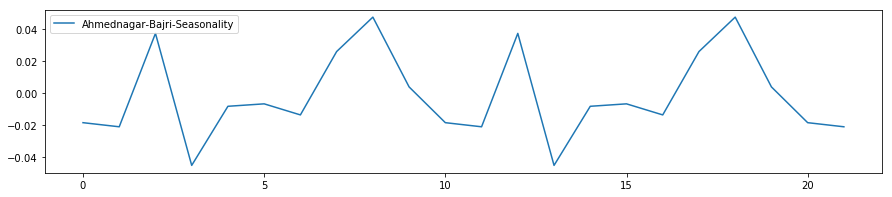

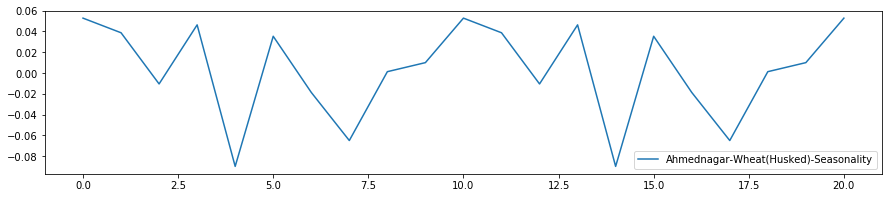

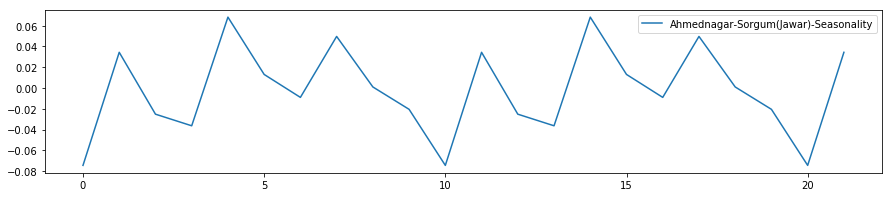

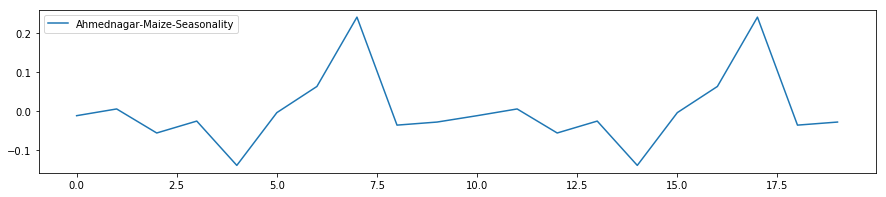

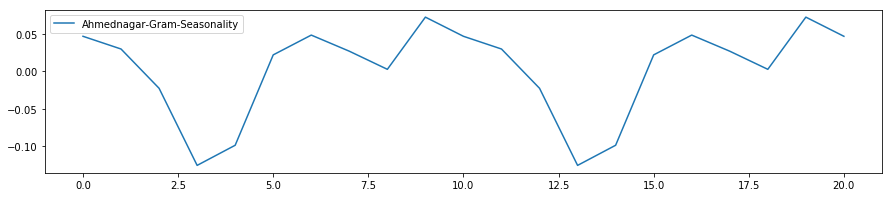

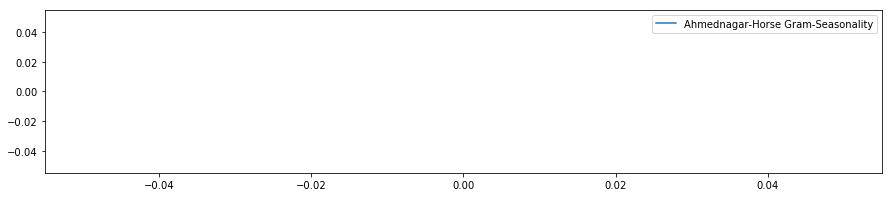

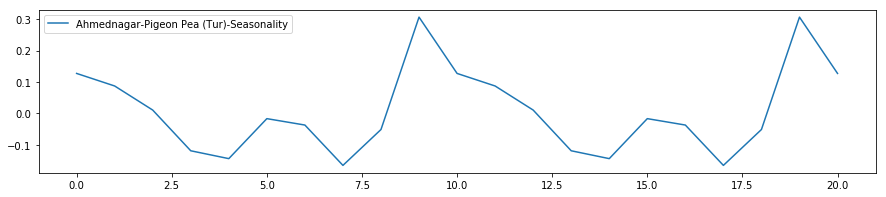

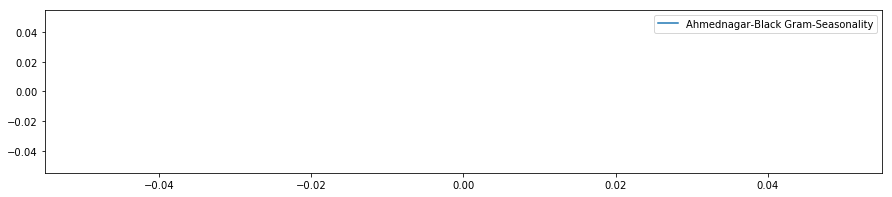

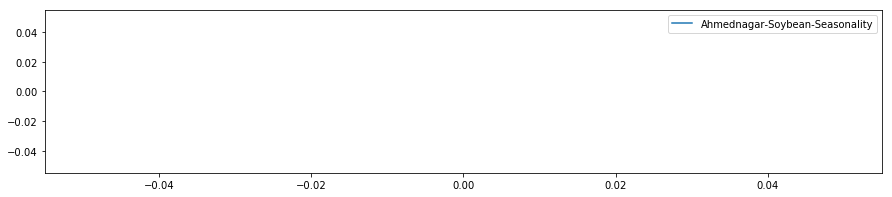

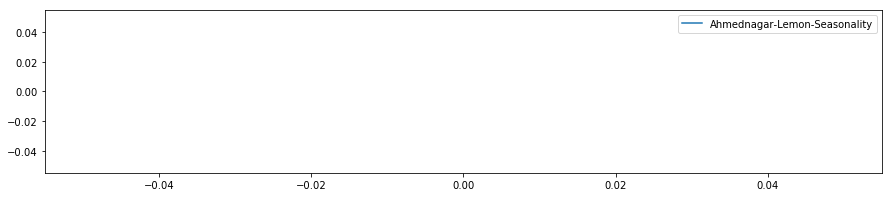

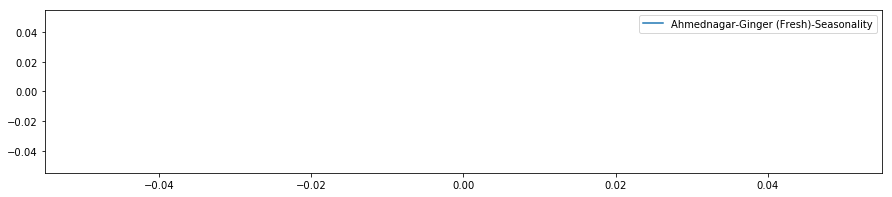

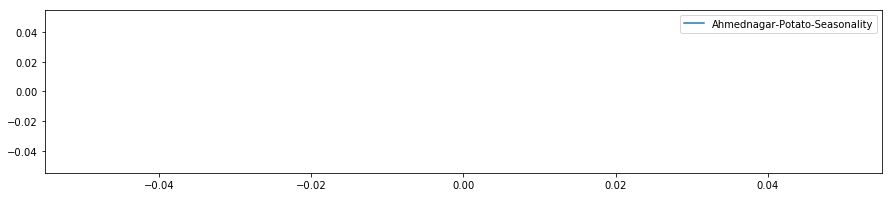

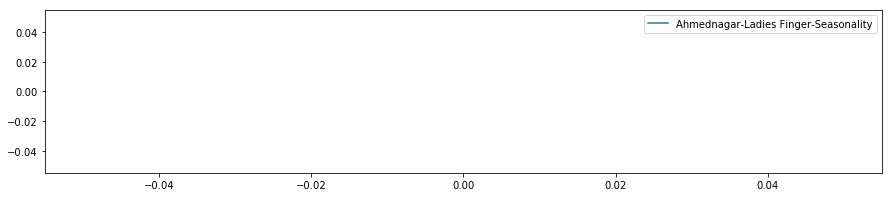

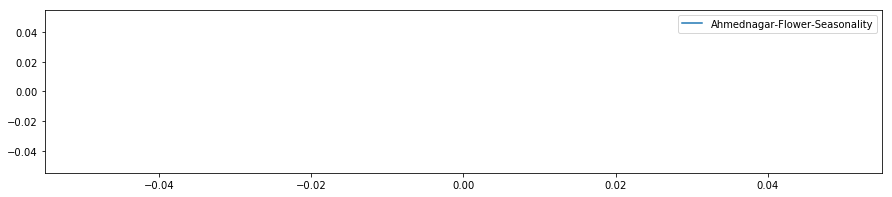

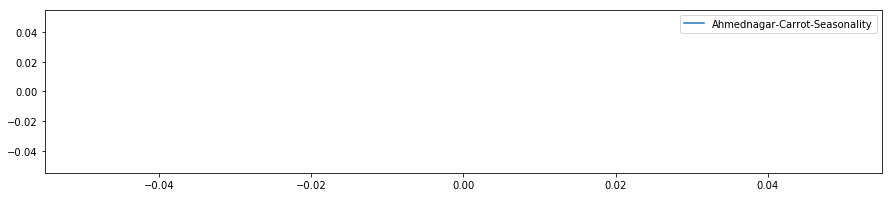

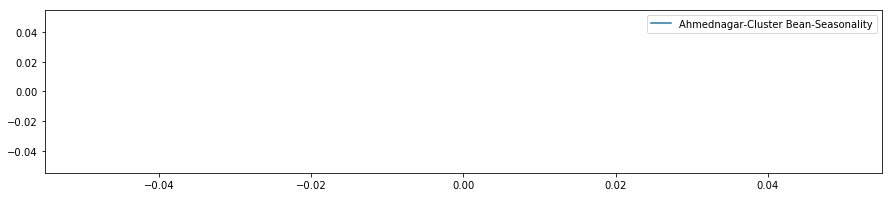

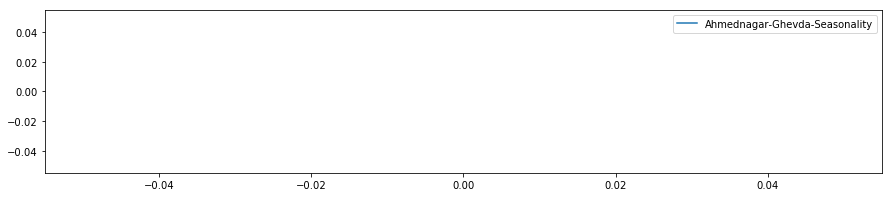

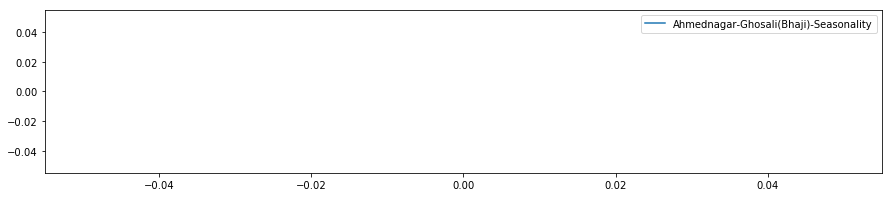

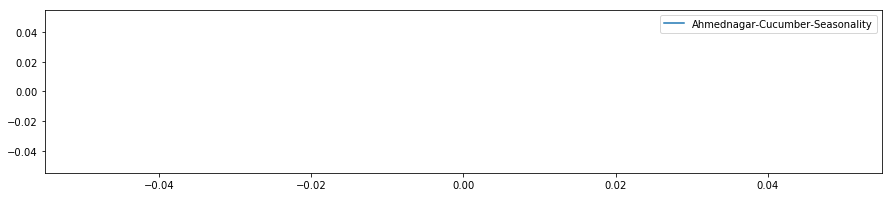

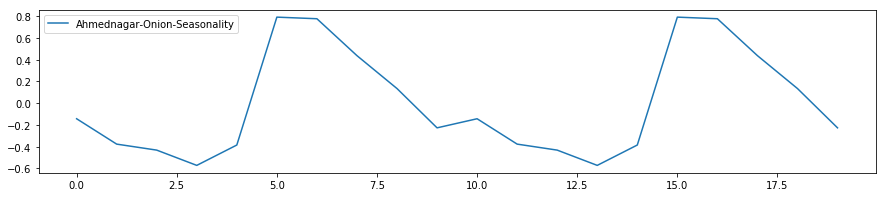

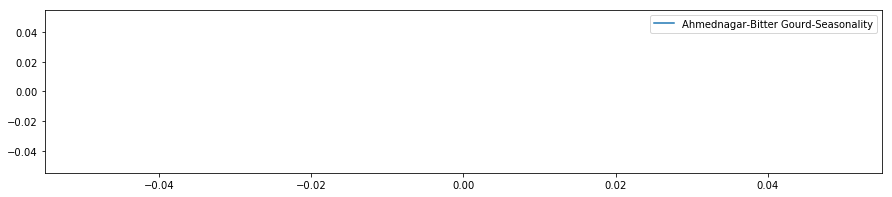

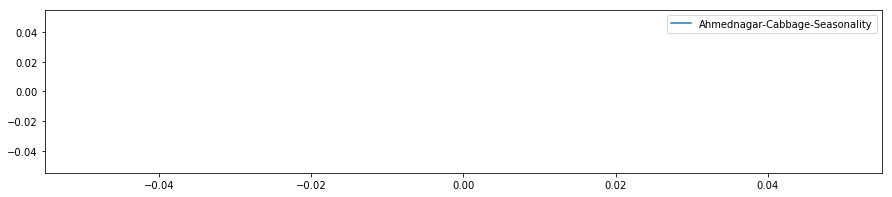

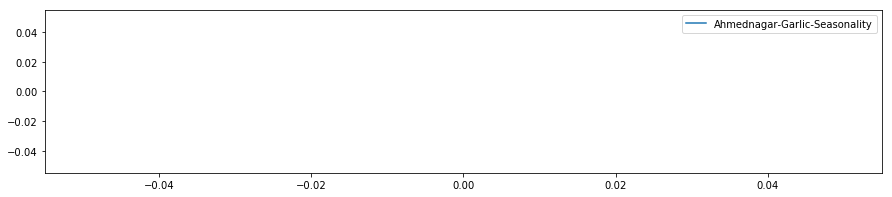

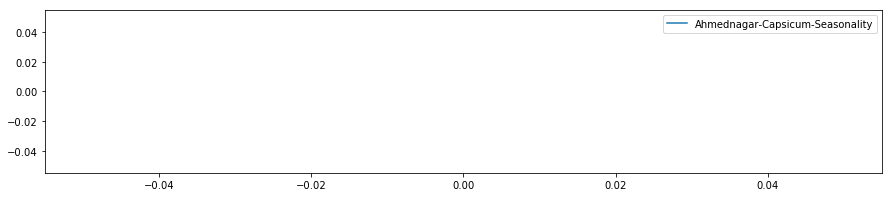

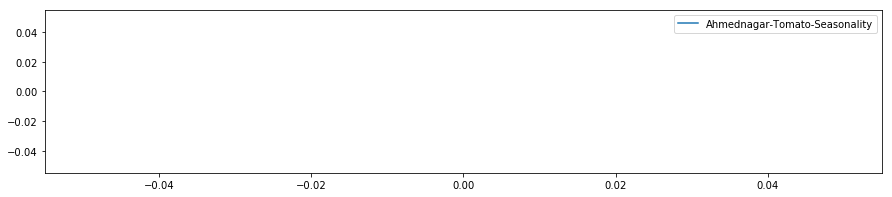

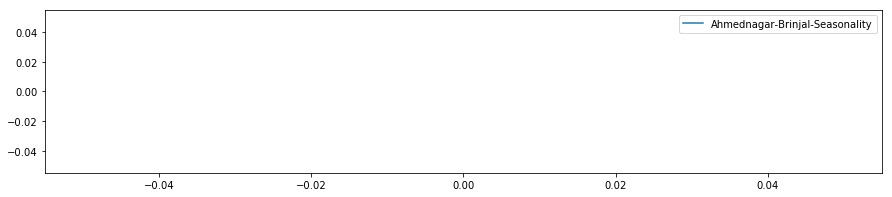

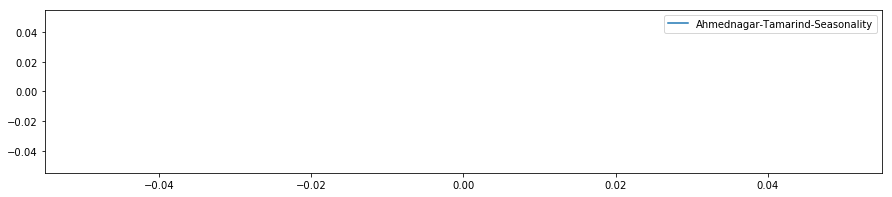

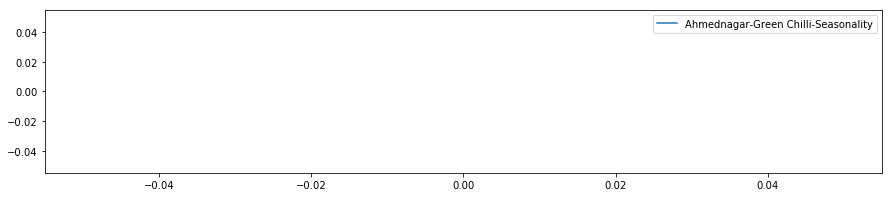

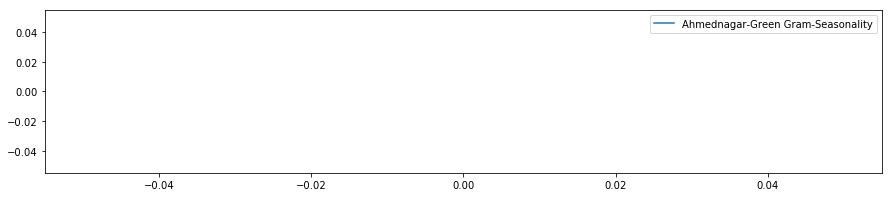

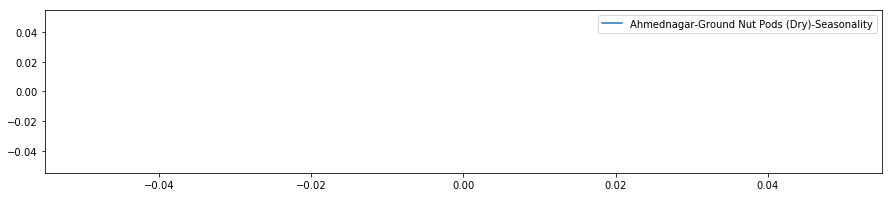

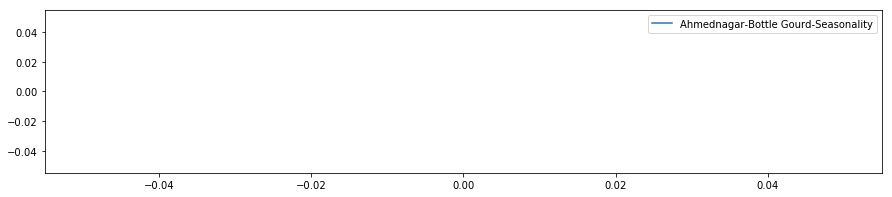

In [17]:
for apmc in ts.APMC.unique()[:1]:
    for commodity in ts.Commodity[ts.APMC==apmc].unique():
        try:
            ts_log = sub(commodity,apmc)
            get_season(ts_log,commodity,apmc)
        except:
            pass
    

In [19]:
ts[(ts.APMC=='Ahmednagar') & (ts.Commodity=='Lemon')]

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,district_name,state_name
date,,,,,,,,,,
2016-04-01,Ahmednagar,Lemon,2016,April,106,2750,6625,5500,Ahmadnagar,Maharashtra
2015-08-01,Ahmednagar,Lemon,2015,August,75,840,1620,1230,Ahmadnagar,Maharashtra
2016-08-01,Ahmednagar,Lemon,2016,August,188,1139,3322,2231,Ahmadnagar,Maharashtra
2015-12-01,Ahmednagar,Lemon,2015,December,168,888,2750,1844,Ahmadnagar,Maharashtra
2016-02-01,Ahmednagar,Lemon,2016,February,34,1000,2767,1967,Ahmadnagar,Maharashtra
2016-01-01,Ahmednagar,Lemon,2016,January,135,1571,3071,2321,Ahmadnagar,Maharashtra
2015-07-01,Ahmednagar,Lemon,2015,July,298,1450,2275,1863,Ahmadnagar,Maharashtra
2016-07-01,Ahmednagar,Lemon,2016,July,206,1136,3341,2261,Ahmadnagar,Maharashtra
2015-06-01,Ahmednagar,Lemon,2015,June,207,833,2583,1708,Ahmadnagar,Maharashtra


* The two CSV files represent time series data
* We would deal with the dataframe containing only those 'years' which are present in both the datasets

In [ ]:
available_year_data = sorted(list(set(monthly_data['year'].unique()).intersection(set(cmo_msp_mandi['year'].unique()))))
print(available_year_data)

* In the following snippent, we alter the fields to represent prices per arrived quintal
* We remove the cases where `modal_price` doesn't lie between `min_price` and `max_price`
* `min_price` would now represent minimum price per arrived quintal i.e. `min_per_quintal`
* `max_price` -> `max_per_qtl`
* `modal_price` -> `mod_per_qtl`
* The edited dataframe is called `new`

In [ ]:
df = monthly_data[((monthly_data['modal_price'] <= monthly_data['max_price']) & 
                 (monthly_data['modal_price'] >= monthly_data['min_price']))]

new = df.drop(['state_name'],axis=1)

new['min_price'] = new['min_price']/new['arrivals_in_qtl']
new['max_price'] = new['max_price']/new['arrivals_in_qtl']
new['modal_price'] = new['modal_price']/new['arrivals_in_qtl']

new.rename(columns={'min_price':"min_per_qtl",},inplace=True)
new.rename(columns={'max_price':"max_per_qtl",},inplace=True)
new.rename(columns={'modal_price':"mod_per_qtl",},inplace=True)

In [ ]:
new.head()

`get_graph()` would be used to get series plots for each commodity from a APMC cluster

In [ ]:
seasonal = []

def enter_seasonal(commodity):
    if commodity not in seasonal:
        seasonal.append(commodity)
    
def get_graph(apmc,commodity):
    seasonal = []
    seas = 0
    try:
        x_14 = new[(new['APMC']==apmc) & (new['commodity']==commodity) & (new['year']==2014)]
        x_14.sort_values(by='date').set_index('month').plot(stacked=True,kind="bar",y=['min_per_qtl','mod_per_qtl','max_per_qtl'],figsize=[15,5],title='{}-{}-2014'.format(apmc,commodity))
    except:
        seas += 1
    try:
        x_15 = new[(new['APMC']==apmc) & (new['commodity']==commodity) & (new['year']==2015)]
        x_15.sort_values(by='date').set_index('month').plot(stacked=True,kind="bar",y=['min_per_qtl','mod_per_qtl','max_per_qtl'],figsize=[15,5],title='{}-{}-2015'.format(apmc,commodity))
    except:
        seas += 1
    try:
        x_16 = new[(new['APMC']==apmc) & (new['commodity']==commodity) & (new['year']==2016)]
        x_16.sort_values(by='date').set_index('month').plot(stacked=True,kind="bar",y=['min_per_qtl','mod_per_qtl','max_per_qtl'],figsize=[15,5],title='{}-{}-2016'.format(apmc,commodity))
    except:
        seas +=1
    if(seas>1):
        enter_seasonal(commodity)
    

In [ ]:
def get_all_graphs_for_apmc(apmc):
    for commodity in new.commodity.unique():
        get_graph(apmc,commodity)
    
def get_all_graphs():
    for apmc in new.APMC.unique():
        for commodity in new.commodity.unique():
            get_graph(apmc,commodity)

* In the following example we are plotting `price per quintal` against `months` for the commodity `Bajri` in `Ahmednagar`.
* The months in which the demand (`arrival_in_qtl`) was less, the prices per quintal were extremely high
* The months in which the demand (`arrival_in_qtl`) was more, the prices per quintal were optimimum
* In Sept, 2014, the `arrival_in_qtl` was low and hence the prices were increased
* In 2015, prices skyrocketed in the order of `Feb` > `March` > `August` > `September`
* In 2016, we witness a similar trend in skyrocketed prices `March` > `August` > `September`
* We can roughly estimate the seasonal type to be `Additive`
* April '15 and '16 show similar trends
* `October` seems like a seasonal month for `Bajri`  
-----
* During months of inflated prices, it is not necessary that the goods will sell as likely as during the months of optimum prices
* This may pose a financial threat to farmers and vendors, who require much more resources to grow non-season crops.
* Eg. the vendors/farmers may receive Rs. 0.91 only from govt. against the probable mod_per_qtl of Rs. 4 - 165 for Bajri, in 2015

In [ ]:
get_graph('Ahmednagar','Bajri')

In [ ]:
h = new[(new.commodity=='Bajri') & (new.APMC=='Ahmednagar')].sort_values(by='date')
h['arrivals_norm'] = ((h['arrivals_in_qtl'] - h['arrivals_in_qtl'].mean())/(h['arrivals_in_qtl'].max() - h['arrivals_in_qtl'].min()))
h.sort_values(by='date').set_index('date').plot(kind="bar",y=['arrivals_norm'],figsize=[20,10],title="Normalised arrival_in_qtl")

In [ ]:
x_16 = new[ (new['APMC']=='Ahmednagar') & (new['year']==2016)]
x_16.sort_values(by='date').set_index('month').index

In [ ]:
df.tail(20)

In [ ]:
new.commodity.unique()

In [ ]:
get_all_graphs_for_apmc('Ahmednagar')

In [ ]:
seasonal

In [ ]:
get_graph('Ahmednagar','Gram')

In [ ]:
field_names = ['year','APMC','commodity','type','msprice','min_price','max_price','modal_price']

In [ ]:
with open("cleaned_APMC.csv","w+") as file:
    writer = csv.DictWriter(file,fieldnames=field_names)
    writer.writeheader()    

In [ ]:
cmo_msp_mandi_2014 = cmo_msp_mandi[cmo_msp_mandi['year']==2014]
cmo_msp_mandi_2015 = cmo_msp_mandi[cmo_msp_mandi['year']==2015]
cmo_msp_mandi_2016 = cmo_msp_mandi[cmo_msp_mandi['year']==2016]

monthly_data_2014 = monthly_data[monthly_data['year']==2014]
monthly_data_2015 = monthly_data[monthly_data['year']==2015]
monthly_data_2016 = monthly_data[monthly_data['year']==2016]

In [ ]:
#
# Module to plot the Min, Max and Modal Prices of every city
#

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
xticks = ['January','February','March','April','May','June','July','August','September','October','November','December']

def get_apmc(data):
    return list(data.APMC.unique())
    
def get_df(data,apmc):
    df_1 = monthly_data[(monthly_data['commodity']=='Bajri') & (monthly_data['APMC']==apmc) & (monthly_data['year']==2014)]
    df_2 = monthly_data[(monthly_data['commodity']=='Bajri') & (monthly_data['APMC']==apmc) & (monthly_data['year']==2015)]
    df_3 = monthly_data[(monthly_data['commodity']=='Bajri') & (monthly_data['APMC']==apmc) & (monthly_data['year']==2016)]
    
def mini(df,xticks,arr):
    for month in xticks:
        if month in list(df.Month.unique()):
            arr.append(list(df.min_price[df['Month']==month])[0])
        else:
            arr.append(0)
            
def maxi(df,xticks,arr):
    for month in xticks:
        if month in list(df.Month.unique()):
            arr.append(list(df.max_price[df['Month']==month])[0])
        else:
            arr.append(0)

def modal(df,xticks,arr):
    for month in xticks:
        if month in list(df.Month.unique()):
            arr.append(list(df.modal_price[df['Month']==month])[0])
        else:
            arr.append(0)

def arrival(df,xticks,arr):
    for month in xticks:
        if month in list(df.Month.unique()):
            arr.append(list(df.arrivals_in_qtl[df['Month']==month])[0])
        else:
            arr.append(0)

apmc_list = get_apmc(monthly_data)

for a in apmc_list:
    min_val_3 = []
    min_val_1 = []
    min_val_2 = []
    max_val_3 = []
    max_val_1 = []
    max_val_2 = []
    modal_val_3 = []
    modal_val_1 = []
    modal_val_2 = []
    arrival_1 = []
    arrival_2 = []
    arrival_3 = []

    df_1 = monthly_data[(monthly_data['commodity']=='Bajri') & (monthly_data['APMC']==a) & (monthly_data['year']==2014)]
    df_2 = monthly_data[(monthly_data['commodity']=='Bajri') & (monthly_data['APMC']==a) & (monthly_data['year']==2015)]
    df_3 = monthly_data[(monthly_data['commodity']=='Bajri') & (monthly_data['APMC']==a) & (monthly_data['year']==2016)]

    mini(df_1,xticks,min_val_1)
    mini(df_2,xticks,min_val_2) 
    mini(df_3,xticks,min_val_3)
    
    maxi(df_1,xticks,max_val_1) 
    maxi(df_2,xticks,max_val_2) 
    maxi(df_3,xticks,max_val_3) 
    
    modal(df_1,xticks,modal_val_1) 
    modal(df_2,xticks,modal_val_2) 
    modal(df_3,xticks,modal_val_3) 
    
    arrival(df_1,xticks,arrival_1)
    arrival(df_2,xticks,arrival_2)
    arrival(df_3,xticks,arrival_3)
    
    plt.figure(figsize=(10,7))
    plt.xticks(x, xticks)
#     plt.plot(x,min_val_1,label="2014-Min")
#     plt.plot(x,min_val_2,label="2015-Min")
    plt.plot(x,min_val_3,label="2016-Min")
#     plt.plot(x,max_val_1,label="2014-Max")
#     plt.plot(x,max_val_2,label="2015-Max")
    plt.plot(x,max_val_3,label="2016-Max")
#     plt.plot(x,modal_val_1,label="2014-Modal")
#     plt.plot(x,modal_val_2,label="2015-Modal")
    plt.plot(x,modal_val_3,label="2016-Modal")
#     plt.scatter(x,arrival_1,label="2014-Arrival",marker="x")
#     plt.scatter(x,arrival_2,label="2015-Arrival",marker="+")
    plt.scatter(x,arrival_3,label="2016-Arrival")
    plt.legend()
    plt.suptitle(a)
    plt.show()

In [ ]:
x = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
xticks = ['January','February','March','April','May','June','July','August','September','October','November','December']

def get_apmc(data):
    return list(data.APMC.unique())

apmc_list = get_apmc(monthly_data)

def arrival(df,xticks,arr):
    for month in xticks:
        if month in list(df.Month.unique()):
            arr.append(list(df.arrivals_in_qtl[df['Month']==month])[0])
        else:
            arr.append(0)
            
for a in apmc_list:
    
    df_1 = monthly_data[(monthly_data['commodity']=='Bajri') & (monthly_data['APMC']==a) & (monthly_data['year']==2014)]
    df_2 = monthly_data[(monthly_data['commodity']=='Bajri') & (monthly_data['APMC']==a) & (monthly_data['year']==2015)]
    df_3 = monthly_data[(monthly_data['commodity']=='Bajri') & (monthly_data['APMC']==a) & (monthly_data['year']==2016)]
    
    arrival_1 = []
    arrival_2 = []
    arrival_3 = []
    
    arrival(df_1,xticks,arrival_1)
    arrival(df_2,xticks,arrival_2)
    arrival(df_3,xticks,arrival_3)
    
    plt.figure(figsize=(7,7))
    plt.xticks(x, xticks)
    plt.scatter(x,arrival_1,label="2014-Arrival",marker="x")
    plt.scatter(x,arrival_2,label="2015-Arrival",marker="+")
    plt.scatter(x,arrival_3,label="2016-Arrival")
    plt.legend()
    plt.suptitle(a)
    plt.show()

In [ ]:
hello = new[(new['min_per_qtl']!=0) | (new['max_per_qtl']!=0) | (new['mod_per_qtl']!=0)]
#hello[hello['commodity']=="Bajri"]
# xy = hello[hello['APMC']=="Akole"]
hello[hello['date']=='2015-04-01']
new = hello[(hello.commodity == "Bajri")]

new.sort_values(by='date').set_index('date').plot(stacked=True,kind="bar",y=['min_per_qtl','mod_per_qtl','max_per_qtl'],figsize=[20,10])
new.sort_values(by='date').set_index('date').plot(kind="bar",y=['arrivals_in_qtl'],figsize=[20,10])

In [ ]:
print(new.arrivals_in_qtl.max())
print(new.arrivals_in_qtl.min())
print(new.arrivals_in_qtl.mean())

norm_check = new
norm_check['arrivals_in_qtl'] = (new['arrivals_in_qtl'] - new['arrivals_in_qtl'].mean())/(new['arrivals_in_qtl'].max() - new['arrivals_in_qtl'].min())
norm_check.sort_values(by='date').set_index('date').plot(kind="bar",y=['arrivals_in_qtl'],figsize=[20,10])

In [ ]:
norm_check.sort_values(by='date')